In [19]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from scipy import stats
from scipy.stats import lognorm
from sklearn.metrics import r2_score

Целью данного исследования является выяснить распределение цен на жилье в датасете цен на дома в Сиэтле и на основе этого построить модель машинного обучение предсказания цены дома.

# Предположение распределения

$H_0$ - Цена имеет предполагаемое распределение

$H_1$ - $\overline{H_0}$

In [20]:
data = pd.read_csv('./kc_house_data.csv')
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

data.drop(columns=['date'], inplace=True)

data.head(5)
data['price'].mean()

np.float64(540088.1417665294)

Проверим пропуски в данных

In [21]:
data.isna().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
month            0
day              0
dtype: int64

Посмотрим через гистограмму как распределены данные по цене

In [22]:
scaled_data = (data["price"] - data["price"].mean())/(data["price"].std()) + 2
fig = px.histogram(
    scaled_data,
    x='price',
    labels={'count': 'Количество домов', 'price': 'Цена'},
    title='Распределение цен на дома в Сиэтле',
)
fig.show()

Видим хвост, хотим более менее цену в среднем рассматривать (в диапазоне 70k-1m) Уберем выбросы.

In [23]:
q94 = stats.quantile(scaled_data, 0.94)
scaled_data = scaled_data[scaled_data <= q94]
fig = px.histogram(
    scaled_data,
    x='price',
    labels={'count': 'Количество домов', 'price': 'Цена x $100,000'},
    title='Распределение цен на дома в Сиэтле (до 99-го перцентиля)',
)
fig.show()

Видим что распределение похожу на логнормальное, гамма или фишерское распределение. Оценим параметры этих распределений и проведем тест Колмогорова-Смирнова для проверки гипотезы $H_0$

In [24]:
mean_, std_ = np.mean(scaled_data), np.std(scaled_data)
log_norm = stats.kstest(scaled_data, 'lognorm', args=(mean_, std_))
gamma_dist = stats.kstest(scaled_data, 'gamma', args=(mean_, std_))
fisher_dist = stats.kstest(scaled_data, 'f', args=(mean_, std_))

print(f"Логнормальное распределение: D = {log_norm.statistic:.6f}, p-значение = {log_norm.pvalue:.32f}")
print(f"Гамма распределение: D = {gamma_dist.statistic:.6f}, p-значение = {gamma_dist.pvalue:.32f}")
print(f"Фишерское распределение: D = {fisher_dist.statistic:.6f}, p-значение = {fisher_dist.pvalue:.32f}")

Логнормальное распределение: D = 0.322806, p-значение = 0.00000000000000000000000000000000
Гамма распределение: D = 0.234109, p-значение = 0.00000000000000000000000000000000
Фишерское распределение: D = 0.483701, p-значение = 0.00000000000000000000000000000000


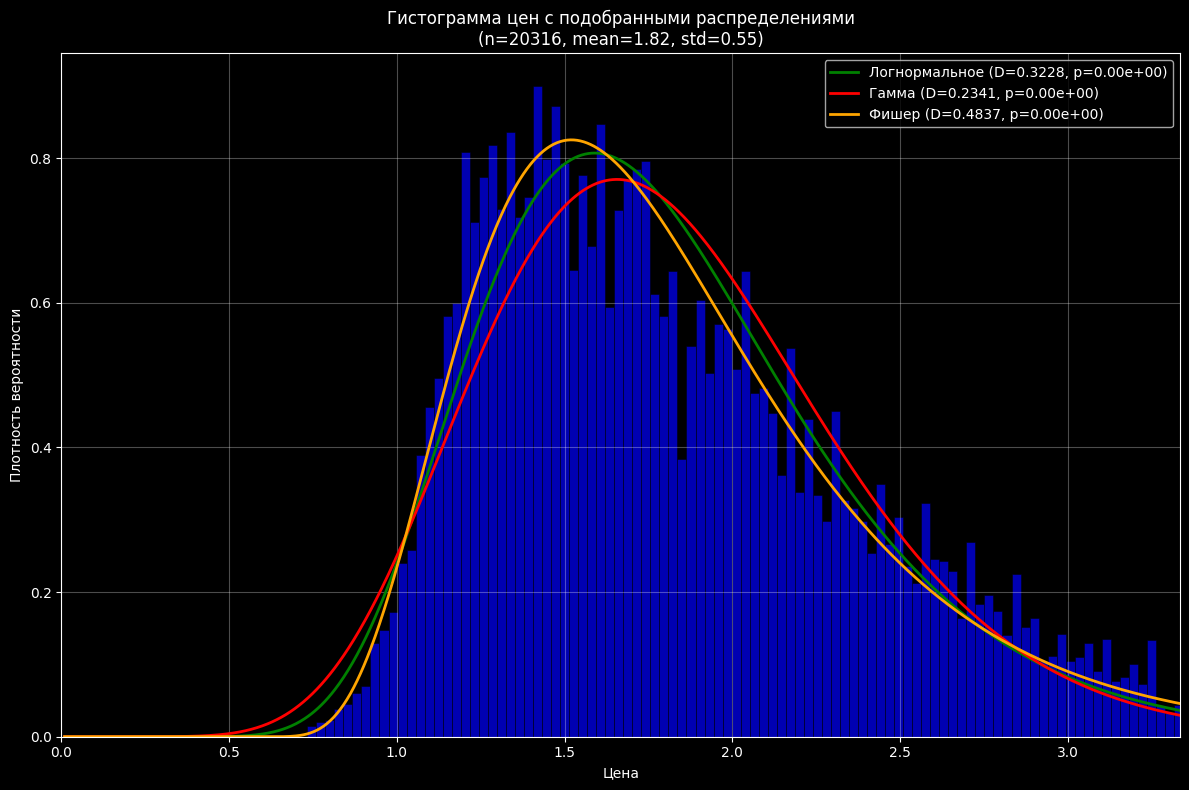

In [25]:
plt.figure(figsize=(12, 8))

hist_counts, hist_bins, _ = plt.hist(scaled_data, alpha=0.7, bins=100,
                                     color='blue', density=True, edgecolor='black', linewidth=0.5)
plt.title('Гистограмма масштабированных цен на дома с подобранными распределениями')
plt.xlabel('Цена')
plt.ylabel('Плотность вероятности')
plt.grid(True, alpha=0.3)

x_limit = np.percentile(scaled_data, 99.5)
plt.xlim(0, x_limit)

x_values = np.linspace(0.01, x_limit, 1000)

if np.all(scaled_data > 0):
    log_data = np.log(scaled_data)
    mu_est = np.mean(log_data)
    sigma_est = np.std(log_data)

    lognorm_pdf = stats.lognorm.pdf(x_values, sigma_est, 0, np.exp(mu_est))
else:
    min_val = np.min(scaled_data)
    shifted_data = scaled_data - min_val + 0.01
    log_shifted = np.log(shifted_data)
    mu_est = np.mean(log_shifted)
    sigma_est = np.std(log_shifted)
    lognorm_pdf = stats.lognorm.pdf(x_values - min_val + 0.01, sigma_est, 0, np.exp(mu_est))

gamma_params = stats.gamma.fit(scaled_data, floc=0)
gamma_pdf = stats.gamma.pdf(x_values, *gamma_params)

f_params = 0
if mean_ > 0 and std_ > 0:
    try:
        f_params = stats.f.fit(scaled_data)
        fisher_pdf = stats.f.pdf(x_values, *f_params)
    except:
        fisher_pdf = stats.f.pdf(x_values, 10, 10, 0, mean_*0.5)
else:
    fisher_pdf = np.zeros_like(x_values)

plt.plot(x_values, lognorm_pdf, 'g-', linewidth=2,
         label=f'Логнормальное (D={log_norm.statistic:.4f}, p={log_norm.pvalue:.2e})')

plt.plot(x_values, gamma_pdf, 'r-', linewidth=2,
         label=f'Гамма (D={gamma_dist.statistic:.4f}, p={gamma_dist.pvalue:.2e})')

plt.plot(x_values, fisher_pdf, 'orange', linewidth=2,
         label=f'Фишер (D={fisher_dist.statistic:.4f}, p={fisher_dist.pvalue:.2e})')

plt.title(f'Гистограмма цен с подобранными распределениями\n'
          f'(n={len(scaled_data)}, mean={mean_:.2f}, std={std_:.2f})')

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

Видим, что эти распределения достаточно хорошо описывают данные, давайте теперь посмотрим на отличия в cdf

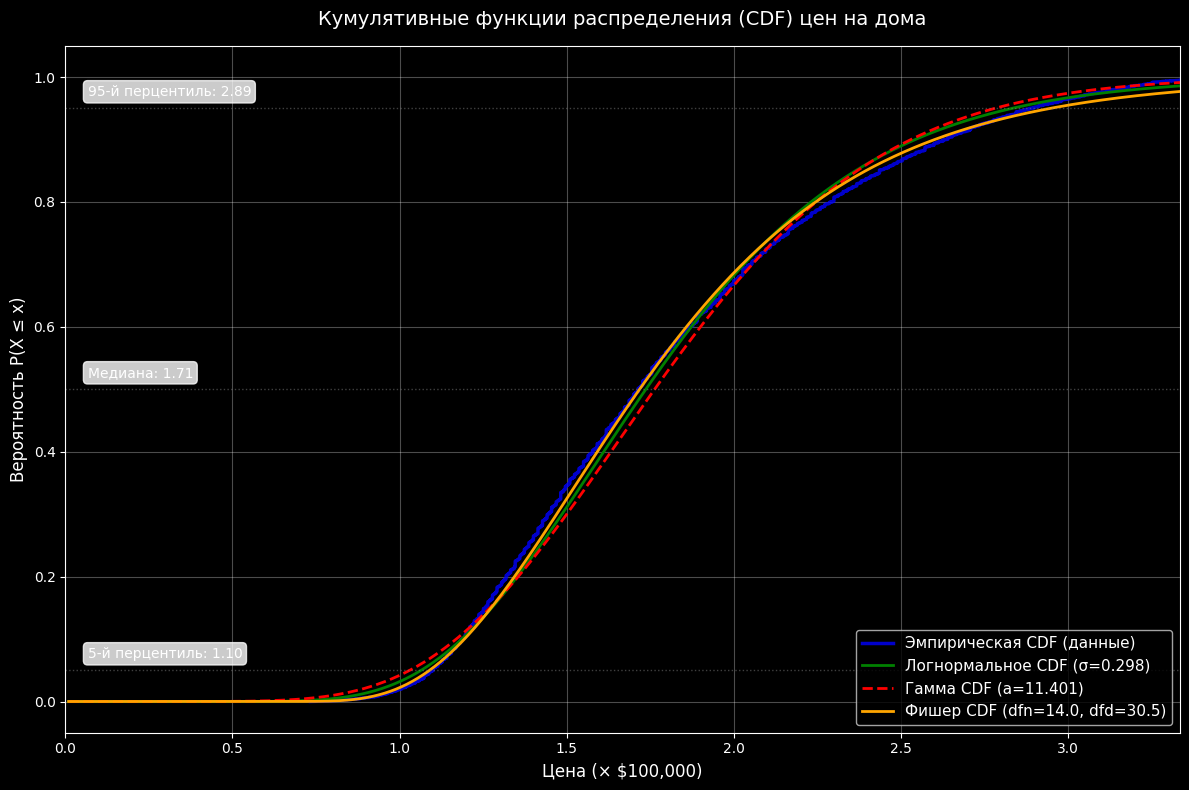

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Логнормальное распределение
if np.all(scaled_data > 0):
    log_data = np.log(scaled_data)
    mu_est = np.mean(log_data)
    sigma_est = np.std(log_data)
else:
    min_val = np.min(scaled_data)
    shifted_data = scaled_data - min_val + 0.01
    log_shifted = np.log(shifted_data)
    mu_est = np.mean(log_shifted)
    sigma_est = np.std(log_shifted)

# 2. Гамма распределение
gamma_params = stats.gamma.fit(scaled_data, floc=0)  # (a, loc=0, scale)

# 3. F-распределение
try:
    f_params = stats.f.fit(scaled_data)
except:
    f_params = (10, 10, 0, np.mean(scaled_data))

x_limit = np.percentile(scaled_data, 99.5)
x_values = np.linspace(0.01, x_limit, 1000)

log_norm_cdf = stats.lognorm.cdf(x_values, s=sigma_est, scale=np.exp(mu_est))
gamma_cdf = stats.gamma.cdf(x_values, *gamma_params)
fisher_cdf = stats.f.cdf(x_values, *f_params)

sorted_data = np.sort(scaled_data)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(12, 8))

plt.plot(sorted_data, empirical_cdf, 'b-', linewidth=2.5,
         label='Эмпирическая CDF (данные)', alpha=0.8)

plt.plot(x_values, log_norm_cdf, 'g-', linewidth=2,
         label=f'Логнормальное CDF (σ={sigma_est:.3f})')

plt.plot(x_values, gamma_cdf, 'r--', linewidth=2,
         label=f'Гамма CDF (a={gamma_params[0]:.3f})')

plt.plot(x_values, fisher_cdf, 'orange', linewidth=2,
         label=f'Фишер CDF (dfn={f_params[0]:.1f}, dfd={f_params[1]:.1f})')

plt.title('Кумулятивные функции распределения (CDF) цен на дома', fontsize=14, pad=15)
plt.xlabel('Цена (× $100,000)', fontsize=12)
plt.ylabel('Вероятность P(X ≤ x)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=11)
plt.xlim(0, x_limit)

plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
plt.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5, linewidth=1)
plt.axhline(y=0.05, color='gray', linestyle=':', alpha=0.5, linewidth=1)

median_price = np.median(scaled_data)
p95_price = np.percentile(scaled_data, 95)
p5_price = np.percentile(scaled_data, 5)

plt.text(x_limit*0.02, 0.52, f'Медиана: {median_price:.2f}', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.text(x_limit*0.02, 0.97, f'95-й перцентиль: {p95_price:.2f}', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.text(x_limit*0.02, 0.07, f'5-й перцентиль: {p5_price:.2f}', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

видим, что логнормальное и гамма распределения подходят лучше всего, проверим это с помощью теста, посмотрим на отклонения эмпирической cdf от теоретической

1. Оптимизация Логнормального распределения...


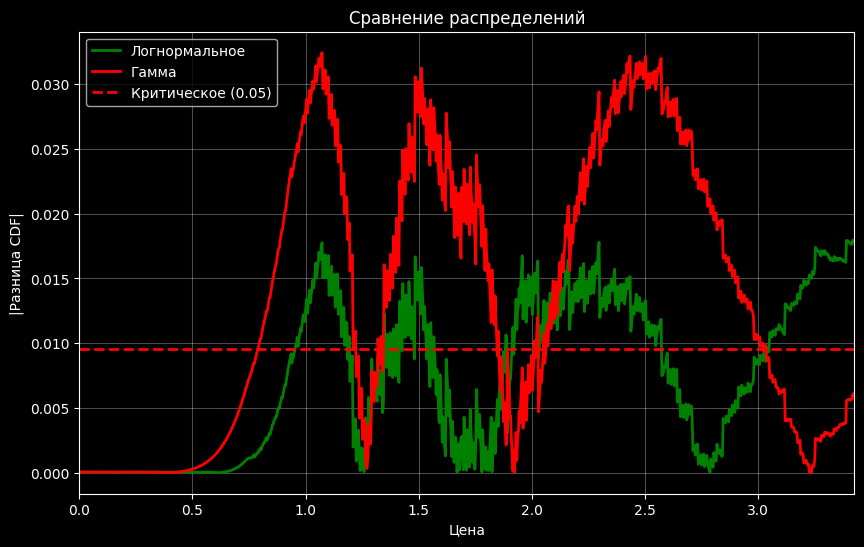

----------------------------------------
Критический порог: 0.00954
----------------------------------------


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

sorted_data = np.sort(scaled_data)
n = len(sorted_data)
y_ecdf = np.arange(1, n + 1) / n

x_limit = np.max(sorted_data)
x_values = np.linspace(0, x_limit, 1000)
ecdf_interp = np.interp(x_values, sorted_data, y_ecdf)

ks_critical = 1.36 / np.sqrt(n)

print("1. Оптимизация Логнормального распределения...")


def ks_loss_lognorm(params, x_data, y_data):
    s, loc, scale = params
    if s <= 0 or scale <= 0: return 1e6
    cdf = stats.lognorm.cdf(x_data, s, loc, scale)
    return np.max(np.abs(y_data - cdf))


start_log = stats.lognorm.fit(scaled_data)

res_log = minimize(ks_loss_lognorm, start_log, args=(sorted_data, y_ecdf), method='Nelder-Mead')
params_log_opt = res_log.x

cdf_log_opt = stats.lognorm.cdf(x_values, *params_log_opt)
diff_log_opt = np.abs(ecdf_interp - cdf_log_opt)


def ks_loss_gamma(params, x_data, y_data):
    a, loc, scale = params
    if a <= 0 or scale <= 0:
        return 1e6
    cdf = stats.gamma.cdf(x_data, a, loc, scale)
    return np.max(np.abs(y_data - cdf))

start_gamma = stats.gamma.fit(scaled_data, floc=0)

res_gamma = minimize(ks_loss_gamma, start_gamma, args=(sorted_data, y_ecdf), method='Nelder-Mead')
params_gamma_opt = res_gamma.x

cdf_gamma_opt = stats.gamma.cdf(x_values, *params_gamma_opt)
diff_gamma_opt = np.abs(ecdf_interp - cdf_gamma_opt)

plt.figure(figsize=(10, 6))
plt.plot(x_values, diff_log_opt, 'g-', linewidth=2, label='Логнормальное')
plt.plot(x_values, diff_gamma_opt, 'r-', linewidth=2, label='Гамма')
plt.axhline(ks_critical, color='r', ls='--', linewidth=2, label='Критическое (0.05)')
plt.title('Сравнение распределений')
plt.xlabel('Цена')
plt.ylabel('|Разница CDF|')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, x_limit)
plt.show()

print("-" * 40)
print(f"Критический порог: {ks_critical:.5f}")
print("-" * 40)

max_diff_gamma = np.max(diff_gamma_opt)

Видим, что оба распределения не проходят $\alpha = 0.05$, так что выберем из того, что лучше всего нам подходи по итогам тестов -- логнормальное

$H_0$ - не отвергается и берется за логнормальное распределение

# Правда ли, что при увеличении "жилищной площади" растет и цена?

Приведем к нормальному распределению цену с помощью логарифмирования

In [28]:
scaled_data_log = np.log1p(scaled_data)
q99 = stats.quantile(scaled_data_log, 0.99)
px.histogram(
    scaled_data_log[scaled_data_log <= q99],
    x='price',
    labels={'count': 'Количество домов', 'price': 'Логарифм цены'},
    title='Распределение логарифма цен на дома в Сиэтле',
)

Сделав вывод о том, как распределены данные, обучим градиентный бустинг с помощью XGBoost пролографимирова данные, возьмем MSE,  отберем по квантилю 94% цены, чтобы было меньше выбросов (выброс считается, если > 1.1m$), и поподбираем гиперпараметры для модели

In [29]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

data_price_q99 = data[data['price'] <= stats.quantile(data['price'], 0.94)]

X = data_price_q99.drop(columns=['price'])
y = data_price_q99['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [500, 1000, 2000],
    "max_depth": [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=1
)

print("Начинаем обучение...")
grid_search.fit(X_train_scaled, y_train_log)

log_rmse = -grid_search.best_score_
print(f"\nОшибка в логарифмах (RMSLE): {log_rmse:.5f}")

best_model = grid_search.best_estimator_
preds_log = best_model.predict(X_test_scaled)

preds_real = np.expm1(preds_log)

real_rmse = np.sqrt(mean_squared_error(y_test, preds_real))
real_mae = mean_absolute_error(y_test, preds_real)
r2 = r2_score(y_test, preds_real)

print(f"Ошибка в деньгах (RMSE): {real_rmse:,.0f}")
print(f"Ошибка в деньгах (MAE): {real_mae:,.0f}")
print(f"R2 Score: {r2:.4f}")

Начинаем обучение...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Ошибка в логарифмах (RMSLE): 0.15468
Ошибка в деньгах (RMSE): 70,244
Ошибка в деньгах (MAE): 48,655
R2 Score: 0.8766


Метрики хорошие, но хочется чуть-чуть улучшить модель, займемся Feature Engineering, будем смотреть таблицу, строить гипотезы и проверить на статистических тестах

In [30]:
data.head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


## Формулировка гипотез

$H_0$ - Есть статистическая зависимость между площадью и ценой

$H_1$ - $\overline{H_0}$

## Выбор уровня значимости
$$\alpha =
0.05$$

## Первый тест

Тест на коэффициент корреляции Пирсона позволяет проверить численно зависимость между ценой и площадью (т.е. проверить гипотезу $H_1$)

$$
r = \frac{\sum (x - m_x) (y - m_y)}
                 {\sqrt{\sum (x - m_x)^2 \sum (y - m_y)^2}}
$$

## Второй тест
Тест Спирмена покажет направление и силу монотонной связи между ценой и площадью

Сначала с помощью МНК оценивается модель регрессии:
$$
y_t = x^T_t \cdot b + \varepsilon_t
$$

Далее ранжируем остатки $e_t$ и переменную $z_t$, от которой предполагается зависимость дисперсии случайных ошибок, и определяется коэффициент Спирмена:
$$
\rho = 1 - \frac{6 \cdot \sum d_t^2}{n(n^2-1)} 
$$ 

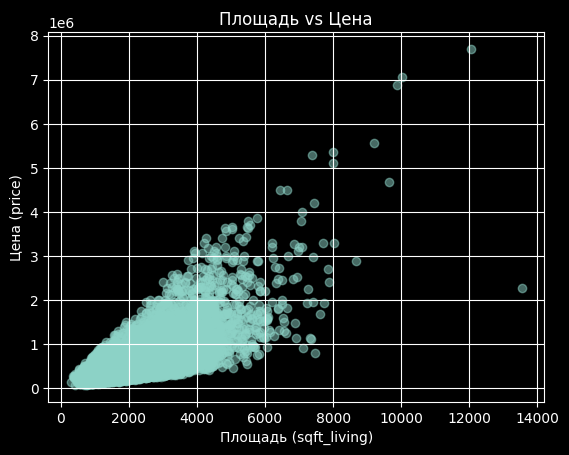

=== Первая часть: Тест на коэффициент корреляции Пирсона ===
Коэффициент корреляции r = 0.70204
P-value = 0.0
=> Отвергаем H_1: есть статистически значимая связь между площадью и ценой.

=== Вторая часть: Тест Спирмена ===
Коэффициент Спирмена ρ = 0.64419
P-value = 0.0
=> Отвергаем H_1: есть монотонная зависимость между площадью и ценой.


In [31]:
data = pd.read_csv('kc_house_data.csv')
sqft_living = data['sqft_living']
price = data['price']

alpha = 0.05

plt.scatter(sqft_living, price, alpha=0.5)
plt.title('Площадь vs Цена')
plt.xlabel('Площадь (sqft_living)')
plt.ylabel('Цена (price)')
plt.grid(True)
plt.show()

r, p_pearson = stats.pearsonr(sqft_living, price)
print("=== Первая часть: Тест на коэффициент корреляции Пирсона ===")
print(f"Коэффициент корреляции r = {r:.5f}")
print(f"P-value = {p_pearson}")

if p_pearson < alpha:
    print("=> Отвергаем H_1: есть статистически значимая связь между площадью и ценой.")
else:
    print("=> Нет оснований отвергнуть H_0: связи не обнаружено.")

rho, p_spearman = stats.spearmanr(sqft_living, price, alternative="greater")
print("\n=== Вторая часть: Тест Спирмена ===")
print(f"Коэффициент Спирмена ρ = {rho:.5f}")
print(f"P-value = {p_spearman}")

if p_spearman < alpha:
    print("=> Отвергаем H_1: есть монотонная зависимость между площадью и ценой.")
else:
    print("=> Нет оснований в отвержении H_1: монотонной зависимости не обнаружено.")


# Правда ли, что цена на старый и новый фонд распределена одинаково?


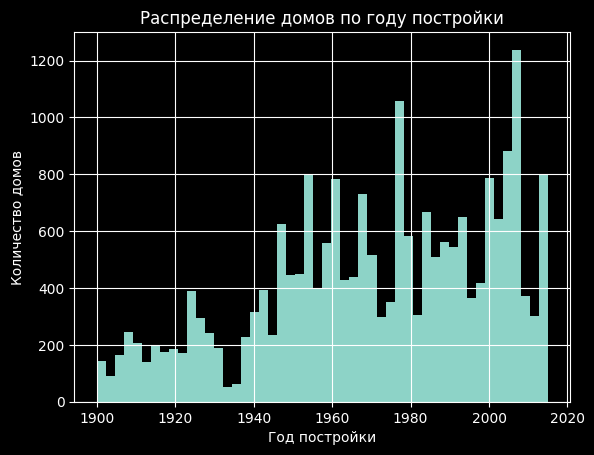

In [32]:
data['yr_built'].hist(bins=50)
plt.xlabel('Год постройки')
plt.ylabel('Количество домов')
plt.title('Распределение домов по году постройки')
plt.show()

  На гистограмме видно, что до 1940 года количество построек было сравнительно небольшим и стабильным, тогда как после 1935 года начался заметный рост строительства.  
В связи с этим, в качестве порогового года был выбран 1940 год.

## Формулировка гипотез

$H_0$ - распределение цен на недвижимость одинаково для старого и нового фонда.

$H_1$ - распределения цен различаются между старым и новым фондом.

## Выбор уровня значимости
$$\alpha =
0.05$$

## Первый тест

Критерий Колмогорова для двух выборок позволяет проверить гипотезу о том, что обе выборки имеют одно и то же распределение. Статистика критерия определяется как:

$$
D = \sup_x |F_1(x) - F_2(x)|
$$

где $F_1(x)$ и $F_2(x)$ — эмпирические функции распределения выборок.

Критическое значение статистики рассчитывается по формуле:

$$
D_{\text{crit}} = c(\alpha) \times \sqrt{\frac{n_1 + n_2}{n_1 n_2}}
$$

где:
- $n_1$, $n_2$ — размеры выборок,
- $c(\alpha)$ — табличное значение, для уровня значимости $\alpha = 0.05$, $c(0.05) = 1.36$.


In [33]:
old_fund = data[data['yr_built'] < 1935]['price']
new_fund = data[data['yr_built'] >= 1935]['price']

ks_statistic, ks_p_value = stats.ks_2samp(old_fund, new_fund)
print("Результаты критерия Колмогорова-Смирнова:")
print(f"D-статистика: {ks_statistic:.5f}")
print(f"P-value: {ks_p_value}")

if ks_p_value < 0.05:
    print("Вывод: Нулевая гипотеза отвергается.")
else:
    print("Вывод: Нет оснований отвергать нулевую гипотезу.")

t_statistic, t_p_value = stats.ttest_ind(old_fund, new_fund, equal_var=False)
print(f"\nРезультаты t-теста:")
print(f"t-статистика: {t_statistic:.5f}")
print(f"p-value: {t_p_value}")

if t_p_value < 0.05:
    print("Вывод: Нулевая гипотеза отвергается.")
else:
    print("Вывод: Нет оснований отвергать нулевую гипотезу.")


Результаты критерия Колмогорова-Смирнова:
D-статистика: 0.15424
P-value: 2.329258350277748e-52
Вывод: Нулевая гипотеза отвергается.

Результаты t-теста:
t-статистика: 9.25026
p-value: 3.707337256896438e-20
Вывод: Нулевая гипотеза отвергается.


# Выводы исследования

В ходе работы был проведен EDA, проверка статистических гипотез и построение модели машинного обучения для предсказания цен на недвижимость в Сиэтле.

**1. Анализ распределения целевой переменной**
*   Гистограмма цен продемонстрировала наличие «тяжелого правого хвоста».
*   Сравнительный анализ теоретических распределений (Логнормальное, Гамма, Фишера) показал, что **логнормальное распределение** наилучшим образом описывает данные.
*   Хотя строгий тест Колмогорова-Смирнова формально отверг гипотезу о точном соответствии (из-за высокой чувствительности теста на большой выборке), визуальный анализ CDF и минимизация отклонений подтвердили, что логарифмирование цены является оптимальным шагом для препроцессинга. Это позволило привести целевую переменную к виду, близкому к нормальному.

**2. Моделирование (Machine Learning)**
*   Использование выводов о распределении (логарифмирование таргета) с алгоритмом **XGBoost** позволило построить качественную регрессионную модель.
*   Метрики на тестовой выборке показали высокую предсказательную способность модели (высокий $R^2$ и приемлемые ошибки MAE/RMSE в денежном выражении).

**3. Проверка статистических гипотез**

*   **Гипотеза: Зависимость цены от площади ($H_0$: связи нет)**
    *   Корреляционные тесты Пирсона и Спирмена показали $p\text{-value} \approx 0$.
    *   **Вывод:** Нулевая гипотеза уверенно отвергается. Существует сильная, статистически значимая положительная связь (как линейная, так и монотонная) между жилой площадью (`sqft_living`) и стоимостью дома.

*   **Гипотеза: Различие цен старого и нового фонда ($H_0$: распределения одинаковы)**
    *   Анализ данных выявил переломный момент в объемах строительства в районе 1935-1940 годов. Выборка была разделена на «старый» (до 1935 г.) и «новый» фонд.
    *   Двухвыборочный критерий Колмогорова-Смирнова и t-тест Уэлча показали $p\text{-value} < 0.05$.
    *   **Вывод:** Нулевая гипотеза отвергается. Цены на недвижимость старого и нового фонда имеют **разные функции распределения** и статистически значимо различаются по средним значениям.

**Итог:**
Цены на жилье в Сиэтле имеют логнормальное распределение. Ключевыми факторами, определяющими стоимость, являются жилая площадь (прямая зависимость) и эпоха постройки (распределения цен для исторической и современной застройки неоднородны). Учет этих особенностей позволил построить эффективную модель прогнозирования.